**Exercise 7.21**. Simulate an ARMA(1,1) series with $\phi = 0.7$, $\theta = −0.6$, $n = 48$ but with error terms from a t-distribution with 6 degrees of freedom.

**(a)** Display the sample EACF of the series. Is an ARMA(1,1) model suggested?

**(b)** Estimate $\phi$ and $\theta$ from the series and comment on the results.

**(c)** Repeat parts (a) and (b) with a new simulated series under the same conditions.

**Solution**.

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def generate_arima(phi=[], d=0, theta=[], n=100, distrvs=None):
    """
    Generates an ARIMA distribution with specified phi, d, and theta parameters,
    using the optimally provided random function generator.
    """
    
    ar = np.r_[1, -np.array(phi)]
    ma = np.r_[1, -np.array(theta)]
    Y = ArmaProcess(ar, ma).generate_sample(nsample=n, distrvs=distrvs)
    for i in range(d):
        Y = np.cumsum(Y)
    return Y

In [3]:
from scipy.stats import t

def rt(df):
    """ 
    Returns a function that generates random variables from a t-distribution
    with df degrees of freedom, with signature compatible with the argument
    distrvs in ArmaProcess.generate_sample.
    """
    
    def f(size=None):
        return t.rvs(df, size=size)
    
    return f

In [4]:
from statsmodels.tsa.stattools import acf, pacf

def plot_acf_with_bounds(acf, lower, upper, title='ACF'):
    max_k = len(acf)
    k = range(1, len(acf)+1)
    
    plt.figure(figsize=(12, 4))
    plt.fill_between(k, lower, upper, color='C0', alpha=0.2)

    plt.plot(k, acf, marker='o', linestyle='none', color='C0')
    plt.plot([1, max_k], [0, 0], ls=':', color='C0')
    for i_k, i_rho in zip(k, acf):
        plt.plot([i_k, i_k], [0, i_rho], color='C0')    
    
    plt.xlabel('Lag')
    plt.ylabel(r'$\rho_k$')
    plt.title(title)
    plt.show()

In [5]:
%%capture
%run eacf.py

In [6]:
np.random.seed(1000)
Y = generate_arima(phi=[0.7], theta=[-0.6], n=48, distrvs=rt(6))

**(a)**

In [7]:
eacf(Y);

AR / MA
   0  1  2  3  4  5  6  7  8  9 10 11 12 13
0  x  o  o  o  o  o  o  o  o  o  o  o  o  o
1  x  o  o  o  o  o  o  o  o  o  o  o  o  o
2  o  o  o  o  o  o  o  o  o  o  o  o  o  o
3  x  o  o  o  o  o  o  o  o  o  o  o  o  o
4  o  o  x  o  o  o  o  o  o  o  o  o  o  o
5  x  x  o  o  o  o  o  o  o  o  o  o  o  o
6  x  x  o  o  o  o  o  o  o  o  o  o  o  o
7  x  o  o  o  o  o  o  o  o  o  o  o  o  o


The EACF suggests an MA(1) process, rather than the actual ARMA(1, 1) process.

**(b)**

In [8]:
def estimate_arma11_mom(x):
    # estimate of phi:  r2 / r1
    # estimate of theta: solve r1 = (1 - theta phi) (phi - theta) / (1 - 2 theta phi + theta^2)
    #    (if it has real roots)
    
    r1, r2 = acf(Y, fft=False, nlags=2)[1:]
    phi = r2 / r1
    delta = (phi**2 - 1)*(phi**2 - 4 *phi *r1 + 4*r1**2 - 1)
    if delta < 0:
        # Complex roots, no MOM estimate for theta
        theta = np.nan
    else:
        theta = ((phi**2 - 2 * phi * r1 + 1) - np.sqrt(delta)) / (2 * (phi - r1))
    return phi, theta

In [9]:
phi, theta = estimate_arma11_mom(Y)
print('Method of moments estimate (phi): \t\t%.5f' % phi)
print('Method of moments estimate (theta): \t\t%.5f' % theta)

res = ARIMA(Y, order=(1, 0, 1)).fit(method='mle')
phi, theta = res.arparams[0], -res.maparams[0]
print('Conditional least squares estimate (phi): \t%.5f' % phi)
print('Conditional least squares estimate (theta): \t%.5f' % theta)

Method of moments estimate (phi): 		0.39305
Method of moments estimate (theta): 		nan
Conditional least squares estimate (phi): 	0.28005
Conditional least squares estimate (theta): 	-0.99994


Both methods fail to provide reasonable estimates.

**(c)**

In [10]:
np.random.seed(1001)
Y = generate_arima(phi=[0.7], theta=[-0.6], n=48, distrvs=rt(6))

eacf(Y);

phi, theta = estimate_arma11_mom(Y)
print('Method of moments estimate (phi): \t\t%.5f' % phi)
print('Method of moments estimate (theta): \t\t%.5f' % theta)

res = ARIMA(Y, order=(1, 0, 1)).fit(method='mle')
phi, theta = res.arparams[0], -res.maparams[0]
print('Conditional least squares estimate (phi): \t%.5f' % phi)
print('Conditional least squares estimate (theta): \t%.5f' % theta)

AR / MA
   0  1  2  3  4  5  6  7  8  9 10 11 12 13
0  x  o  o  o  o  o  o  o  o  o  o  o  o  o
1  x  o  o  o  o  o  o  o  o  x  o  o  o  o
2  x  o  o  o  o  o  o  o  o  o  o  o  o  o
3  x  o  o  o  o  o  o  o  o  o  o  o  o  o
4  x  o  o  o  o  o  o  o  o  o  o  o  o  o
5  x  o  o  o  o  o  o  o  o  o  o  o  o  o
6  x  o  o  o  o  o  o  o  o  o  o  o  o  o
7  o  o  o  o  o  o  o  o  o  o  o  o  o  o
Method of moments estimate (phi): 		0.07195
Method of moments estimate (theta): 		nan
Conditional least squares estimate (phi): 	0.18839
Conditional least squares estimate (theta): 	-0.71427


Again EACF suggests a MA(1) process, and again we do not get reasonable parameter estimates.

**Exercise 7.22**.  Simulate an AR(1) series with $\phi = 0.6$, $n = 36$ but with error terms from a chi-square distribution with 6 degrees of freedom.

**(a)** Display the sample PACF of the series. Is an AR(1) model suggested?

**(b)** Estimate $\phi$ from the series and comment on the results.

**(c)** Repeat parts (a) and (b) with a new simulated series under the same conditions.

**Solution**.

In [11]:
from scipy.stats import chi2

def rchisq(df):
    """ 
    Returns a function that generates random variables from a chi square
    distribution with df degrees of freedom, with signature compatible with 
    the argument distrvs in ArmaProcess.generate_sample.
    """
    
    def f(size=None):
        return chi2.rvs(df=df, size=size)
    
    return f

In [12]:
np.random.seed(1000)
Y = generate_arima(phi=[0.6], n=36, distrvs=rchisq(6))

**(a)**

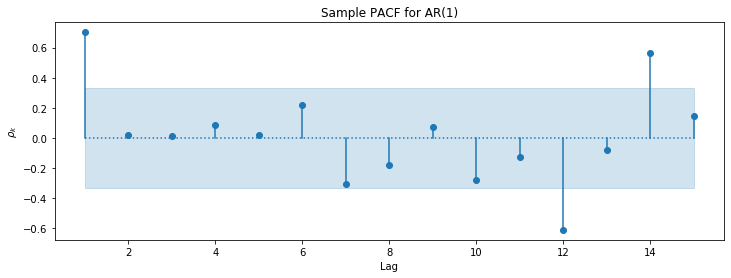

In [13]:
r = pacf(Y, nlags=15)[1:]
se = 1 / np.sqrt(len(Y))
plot_acf_with_bounds(r, -2*se, 2*se, title='Sample PACF for AR(1)')

PACF hints at an AR(1) process, though large lags at 12 and 14 should be investigated.

**(b)**

In [14]:
def estimate_ar1_mom(x):
    return acf(x, fft=False, nlags=1)[1]

In [15]:
print('Method of moments estimate: \t\t%.5f' % estimate_ar1_mom(Y))
print('Maximum likelihood estimate: \t\t%.5f' % ARIMA(Y, order=(1, 0, 0)).fit(method='mle').arparams[0])

Method of moments estimate: 		0.68190
Maximum likelihood estimate: 		0.74849


Both methods provide sensible estimates, though method of moments is closer to the actual value for $\theta$.

**(c)**

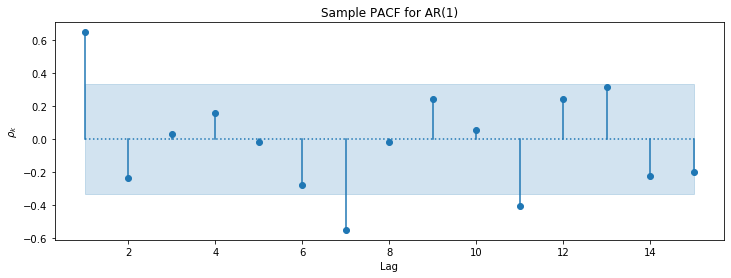

Method of moments estimate: 		0.62945
Maximum likelihood estimate: 		0.80560


In [16]:
np.random.seed(1001)
Y = generate_arima(phi=[0.6], n=36, distrvs=rchisq(6))

r = pacf(Y, nlags=15)[1:]
se = 1 / np.sqrt(len(Y))
plot_acf_with_bounds(r, -2*se, 2*se, title='Sample PACF for AR(1)')

print('Method of moments estimate: \t\t%.5f' % estimate_ar1_mom(Y))
print('Maximum likelihood estimate: \t\t%.5f' % ARIMA(Y, order=(1, 0, 0)).fit(method='mle').arparams[0])

Again PACF suggests AR(1) but with large lags later in the series.

Both estimates are off by about 0.1, but are generally pointing in the right direction.

**Exercise 7.23**.  Simulate an MA(1) series with $\theta = −0.8$, $n = 60$ but with error terms from a chi-square distribution with 7 degrees of freedom.

**(a)** Display the sample ACF of the series. Is an MA(1) model suggested?

**(b)** Estimate $\theta$ from the series and comment on the results.

**(c)** Repeat parts (a) and (b) with a new simulated series under the same conditions.

**Solution**.

In [17]:
np.random.seed(1000)
Y = generate_arima(theta=[-0.8], n=60, distrvs=rchisq(7))

**(a)**

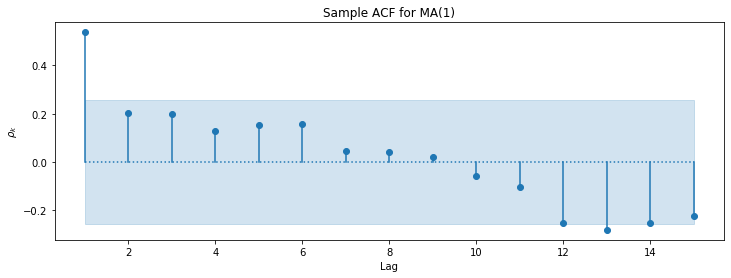

In [18]:
r = acf(Y, fft=False, nlags=15)[1:]
se = 1 / np.sqrt(len(Y))
plot_acf_with_bounds(r, -2*se, 2*se, title='Sample ACF for MA(1)')

Yes, the MA(1) model is suggested (despite large lags later in the series).

**(b)**

In [19]:
def estimate_ma1_mom(x):
    r = acf(x, fft=False, nlags=1)[1]
    if np.abs(r) < 0.5:
        return (-1 + np.sqrt(1 - 4 * r**2))/(2*r)
    return np.nan

In [20]:
print('Method of moments estimate: \t\t%.5f' % estimate_ma1_mom(Y))
print('Maximum likelihood estimate: \t\t%.5f' % -ARIMA(Y, order=(0, 0, 1)).fit(method='mle').maparams[0])

Method of moments estimate: 		nan
Maximum likelihood estimate: 		-0.73749


The method of moments fails to provide an estimate, but hte maximum likelihood method provides a reasonable estimate at $\theta = -0.738$.

**(c)**

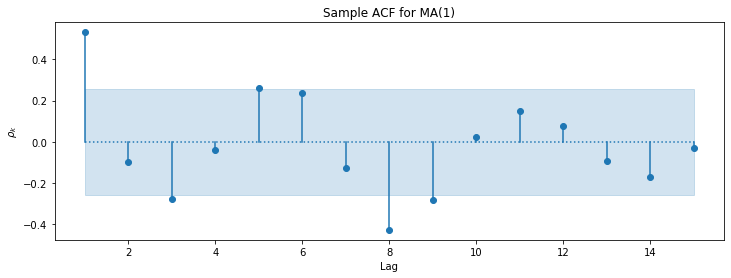

Method of moments estimate: 		nan
Maximum likelihood estimate: 		-0.87484


In [21]:
np.random.seed(1001)
Y = generate_arima(theta=[-0.8], n=60, distrvs=rchisq(7))

r = acf(Y, fft=False, nlags=15)[1:]
se = 1 / np.sqrt(len(Y))
plot_acf_with_bounds(r, -2*se, 2*se, title='Sample ACF for MA(1)')

print('Method of moments estimate: \t\t%.5f' % estimate_ma1_mom(Y))
print('Maximum likelihood estimate: \t\t%.5f' % -ARIMA(Y, order=(0, 0, 1)).fit(method='mle').maparams[0])

Again the ACF suggests MA(1) but it has large values later in the series.

Again the method of moments fails to provide an estimate, while the estimate for the maximum likelihood method is reasonable but a bit far from the true value.

**Exercise 7.24**.  Simulate an AR(2) series with $\phi_1 = 1.0$, $\phi_2 = −0.6$, $n = 48$ but with error terms from a chi-square distribution with 8 degrees of freedom.

**(a)** Display the sample PACF of the series. Is an AR(2) model suggested?

**(b)** Estimate $\phi_1$ and $\phi_2$ from the series and comment on the results.

**(c)** Repeat parts (a) and (b) with a new simulated series under the same conditions

**Solution**.

In [22]:
np.random.seed(2000)
Y = generate_arima(phi=[1.0, -0.6], n=48, distrvs=rchisq(8))

**(a)**

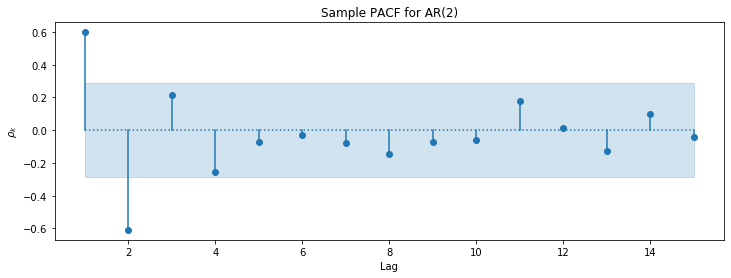

In [23]:
r = pacf(Y, nlags=15)[1:]
se = 1 / np.sqrt(len(Y))
plot_acf_with_bounds(r, -2*se, 2*se, title='Sample PACF for AR(2)')

Yes, the PACF suggests an AR(2) process.

**(b)**

In [24]:
from statsmodels.regression.linear_model import yule_walker

def estimate_ar2_mom(x):
    rho, sigma = yule_walker(x, order=2)
    return rho

In [25]:
phi1, phi2 = estimate_ar2_mom(Y)
print('Method of moments estimate (phi1): \t\t%.5f' % phi1)
print('Method of moments estimate (phi2): \t\t%.5f' % phi2)

phi1, phi2 = ARIMA(Y, order=(2, 0, 0)).fit(method='mle').arparams
print('Maximum likelihood estimate (phi1): \t\t%.5f' % phi1)
print('Maximum likelihood estimate (phi2): \t\t%.5f' % phi2)

Method of moments estimate (phi1): 		0.96254
Method of moments estimate (phi2): 		-0.60917
Maximum likelihood estimate (phi1): 		0.96638
Maximum likelihood estimate (phi2): 		-0.65240


Both methods provide reasonable estimates for $\phi_1$ and $\phi_2$, though method of moment estimates is closer.

**(c)**

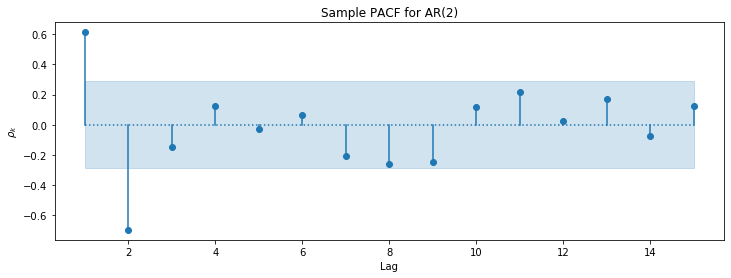

Method of moments estimate (phi1): 		1.04191
Method of moments estimate (phi2): 		-0.69835
Maximum likelihood estimate (phi1): 		1.15671
Maximum likelihood estimate (phi2): 		-0.80994


In [26]:
np.random.seed(2001)
Y = generate_arima(phi=[1.0, -0.6], n=48, distrvs=rchisq(8))

r = pacf(Y, nlags=15)[1:]
se = 1 / np.sqrt(len(Y))
plot_acf_with_bounds(r, -2*se, 2*se, title='Sample PACF for AR(2)')

phi1, phi2 = estimate_ar2_mom(Y)
print('Method of moments estimate (phi1): \t\t%.5f' % phi1)
print('Method of moments estimate (phi2): \t\t%.5f' % phi2)

phi1, phi2 = ARIMA(Y, order=(2, 0, 0)).fit(method='mle').arparams
print('Maximum likelihood estimate (phi1): \t\t%.5f' % phi1)
print('Maximum likelihood estimate (phi2): \t\t%.5f' % phi2)

Again, the PACF suggests an AR(2) process.

The estimates obtained by the method of moments are, again, better than the estimates obtained by the maximum likelihood.

**Exercise 7.25**.  Simulate an ARMA(1,1) series with $\phi = 0.7$, $\theta = −0.6$, $n = 48$ but with error terms from a chi-square distribution with 9 degrees of freedom.

**(a)** Display the sample EACF of the series. Is an ARMA(1,1) model suggested?

**(b)** Estimate $\phi$ and $\theta$ from the series and comment on the results.

**(c)** Repeat parts (a) and (b) with a new series under the same conditions.

**Solution**.

In [27]:
np.random.seed(3000)
Y = generate_arima(phi=[0.7], theta=[-0.6], n=48, distrvs=rchisq(9))

**(a)**

In [28]:
eacf(Y);

AR / MA
   0  1  2  3  4  5  6  7  8  9 10 11 12 13
0  x  o  o  o  o  o  o  o  o  o  o  o  o  o
1  x  o  o  o  o  o  o  o  o  o  o  o  o  o
2  x  x  o  o  o  o  o  o  o  o  o  o  o  o
3  x  x  x  o  o  o  o  o  o  o  o  o  o  o
4  o  o  o  o  o  o  o  o  o  o  o  o  o  o
5  o  o  o  o  o  o  o  o  o  o  o  o  o  o
6  x  o  o  o  o  o  o  o  o  o  o  o  o  o
7  o  x  o  o  o  o  o  o  o  o  o  o  o  o


No -- EACF suggests a MA(1) process, rather than the actual ARMA(1, 1) process.

**(b)**

In [29]:
phi, theta = estimate_arma11_mom(Y)
print('Method of moments estimate (phi): \t\t%.5f' % phi)
print('Method of moments estimate (theta): \t\t%.5f' % theta)

res = ARIMA(Y, order=(1, 0, 1)).fit(method='mle')
phi, theta = res.arparams[0], -res.maparams[0]
print('Conditional least squares estimate (phi): \t%.5f' % phi)
print('Conditional least squares estimate (theta): \t%.5f' % theta)

Method of moments estimate (phi): 		0.30373
Method of moments estimate (theta): 		nan
Conditional least squares estimate (phi): 	0.63179
Conditional least squares estimate (theta): 	-0.84143


Method of moment fails to provide an estimate for $\theta$.  The maximum likelihood estimate values are not too far from the actual values.

**(c)**

In [30]:
np.random.seed(3001)
Y = generate_arima(phi=[0.7], theta=[-0.6], n=48, distrvs=rchisq(9))

eacf(Y);

phi, theta = estimate_arma11_mom(Y)
print('Method of moments estimate (phi): \t\t%.5f' % phi)
print('Method of moments estimate (theta): \t\t%.5f' % theta)

res = ARIMA(Y, order=(1, 0, 1)).fit(method='mle')
phi, theta = res.arparams[0], -res.maparams[0]
print('Conditional least squares estimate (phi): \t%.5f' % phi)
print('Conditional least squares estimate (theta): \t%.5f' % theta)

AR / MA
   0  1  2  3  4  5  6  7  8  9 10 11 12 13
0  x  x  o  o  o  o  o  o  o  o  o  o  o  o
1  x  o  o  o  o  o  o  o  o  o  o  o  o  o
2  x  o  o  o  o  o  o  o  o  o  o  o  o  o
3  x  o  o  o  o  o  o  o  o  o  o  o  o  o
4  x  o  o  o  o  o  o  o  o  o  o  o  o  o
5  x  o  o  o  o  o  o  o  o  o  o  o  o  o
6  x  o  o  o  o  o  o  o  o  o  o  o  o  o
7  o  x  o  o  o  o  o  o  o  o  o  o  o  o
Method of moments estimate (phi): 		0.50659
Method of moments estimate (theta): 		-0.26861
Conditional least squares estimate (phi): 	0.73325
Conditional least squares estimate (theta): 	-0.65583


EACF suggests an ARMA(1, 1) process.

Both methods provide estimates, but the estimates for the maximum likelihood are much better.

**Exercise 7.26**.  Consider the AR(1) model specified for the color property time series displayed in Exhibit 1.3 on page 3.  The data are in the file named `color`.

**(a)** Find the method-of-moments estimate of $\phi$.

**(b)** Find the maximum likelihood estimate of $\phi$ and compare it with part (a).

**Solution**.

In [31]:
Y = pd.read_csv('../data/color.dat')['color']

**(a)**

In [32]:
print('Method of moments estimate: \t\t%.5f' % estimate_ar1_mom(Y))

Method of moments estimate: 		0.52821


**(b)**

In [33]:
print('Maximum likelihood estimate: \t\t%.5f' % ARIMA(Y, order=(1, 0, 0)).fit(method='mle').arparams[0])

Maximum likelihood estimate: 		0.57055


The estimates are within 10% of each other.

**Exercise 7.27**.  Exhibit 6.31 on page 139 suggested specifying either an AR(1) or possibly an AR(4) model for the difference of the logarithms of the oil price series.  The data are in the file named `oil.price`.

**(a)** Estimate both of these models using maximum likelihood and compare it with the results using the AIC criteria.

**(b)** Exhibit 6.32 on page 140 suggested specifying an MA(1) model for the difference of the logs. Estimate this model by maximum likelihood and compare to your results in part (a).

**Solution**.

In [34]:
Y = pd.read_csv('../data/oil.price.dat')['oil.price']
Y = np.diff(np.log(Y))

**(a)**

In [35]:
model_ar1 = ARIMA(Y, order=(1, 0, 0)).fit(method='mle')
model_ar4 = ARIMA(Y, order=(4, 0, 0)).fit(method='mle')

print('AR(1) AIC: %.2f' % model_ar1.aic)
print('AR(4) AIC: %.2f' % model_ar4.aic)

AR(1) AIC: -511.43
AR(4) AIC: -512.32


The AR(1) model has higher AIC (and should be selected according to this criteria).

**(b)**

In [36]:
model_ma1 = ARIMA(Y, order=(0, 0, 1)).fit(method='mle')

print('MA(1) AIC: %.2f' % model_ma1.aic)

MA(1) AIC: -514.94


This model has lower AIC than both the AR models -- we should still prefer the AR(1) model.

**Exercise 7.28**.  The data file named `deere3` contains 57 consecutive values from a complex machine tool at Deere & Co.  The values given are deviations from a target value in units of ten millionths of an inch.  The process employs a control mechanism
that resets some of the parameters of the machine tool depending on the magnitude of deviation from target of the last item produced.

**(a)** Estimate the parameters of an AR(1) model for this series.

**(b)** Estimate the parameters of an AR(2) model for this series and compare the results with those in part (a).

**Solution**.

In [37]:
Y = pd.read_csv('../data/deere3.dat')['deere3']

**(a)**

In [38]:
def print_arima_results(results):
    if len(results.arparams) > 0:
        print('AR params: \t' , results.arparams)
    if len(results.maparams) > 0:
        print('MA params: \t' , results.maparams)
    print('Log-likelihood:  %.2f' % results.llf)
    print('AIC:  \t\t  %.2f' % results.aic)

In [39]:
model_ar1 = ARIMA(Y, order=(1, 0, 0)).fit(method='mle')
print_arima_results(model_ar1)

AR params: 	 [0.52553997]
Log-likelihood:  -495.51
AIC:  		  997.02


**(b)**

In [40]:
model_ar2 = ARIMA(Y, order=(2, 0, 0)).fit(method='mle')
print_arima_results(model_ar2)

AR params: 	 [0.52111738 0.00831627]
Log-likelihood:  -495.51
AIC:  		  999.01


The AR(2) model has higher AIC, and should be preferred.

**Exercise 7.29**.  The data file named `robot` contains a time series obtained from an industrial robot.  The robot was put through a sequence of maneuvers, and the distance from a desired ending point was recorded in inches. This was repeated 324 times to form the time series.

**(a)** Estimate the parameters of an AR(1) model for these data.

**(b)** Estimate the parameters of an IMA(1,1) model for these data.

**(c)** Compare the results from parts (a) and (b) in terms of AIC.

**Solution**.

In [41]:
Y = pd.read_csv('../data/robot.dat')['robot']

**(a)**

In [42]:
model_ar1 = ARIMA(Y, order=(1, 0, 0)).fit(method='mle')
print_arima_results(model_ar1)

AR params: 	 [0.30751394]
Log-likelihood:  1475.54
AIC:  		  -2945.08


**(b)**

In [43]:
model_ima11 = ARIMA(Y, order=(0, 1, 1)).fit(method='mle')
print_arima_results(model_ima11)

MA params: 	 [-0.87161181]
Log-likelihood:  1480.95
AIC:  		  -2955.91


**(c)**  The AR(1) model has higher AIC, and should be selected between these two.

**Exercise 7.30**.  The data file named `days` contains accounting data from the Winegard Co. of Burlington, Iowa. The data are the number of days until Winegard receives payment for 130 consecutive orders from a particular distributor of Winegard products.  (The name of the distributor must remain anonymous for confidentiality reasons.)  The time series contains outliers that are quite obvious in the time series plot.

**(a)** Replace each of the unusual values with a value of 35 days, a much more typical value, and then estimate the parameters of an MA(2) model.

**(b)** Now assume an MA(5) model and estimate the parameters. Compare these results with those obtained in part (a).

**Solution**.

In [44]:
Y = pd.read_csv('../data/days.dat')['days']

**(a)**

In [45]:
Y[Y > 48] = 35

model_ma2 = ARIMA(Y, order=(0, 0, 2)).fit(method='mle')
print_arima_results(model_ma2)

MA params: 	 [0.18925638 0.19576278]
Log-likelihood:  -412.23
AIC:  		  832.45


**(b)**

In [46]:
model_ma5 = ARIMA(Y, order=(0, 0, 5)).fit(method='mle')
print_arima_results(model_ma5)

MA params: 	 [ 0.18445887  0.26804536  0.03058181  0.1716787  -0.08593665]
Log-likelihood:  -409.93
AIC:  		  833.86


The MA(5) model has have higher AIC, and should be selected compared to the MA(2) model.